In [1]:
import torch
from torch import nn
from torch.nn import functional
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorWithPadding
import torch.optim as optim

from dataset.create_dataset import create_data_loader
from layers.model import Transformer, AutoregressiveWrapper
from transformers import BertTokenizer

from test_model.test_model import TestModel
from tqdm import tqdm

import wandb


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="transformer",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "Transformer",
    "dataset": "wikitext",
    "epochs": 10,
    }
)

wandb: Currently logged in as: skorodumov-work (8667). Use `wandb login --relogin` to force relogin


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

embedding_size = 512
max_sequence_length = 512
number_of_tokens = tokenizer.vocab_size
batch_size = 8

model = Transformer(
    embedding_size=embedding_size,
    number_of_tokens=number_of_tokens,
    number_of_heads=4,
    number_of_layers=6,
    dropout_rate=0.1,
    max_sequence_length=max_sequence_length
).to(device)
pipeline = AutoregressiveWrapper(model).to(device)

In [5]:
train_dataloader, test_dataloader, _ = create_data_loader(batch_size=batch_size,
                                    max_sequence_size=max_sequence_length,
                                    train_size=36000, test_size=2000)

Found cached dataset wikitext (C:/Users/skoro/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\skoro\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-ce510edb20811070.arrow
Loading cached processed dataset at C:\Users\skoro\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-ee625925d7e3d1b1.arrow


In [6]:
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
model_tester = TestModel()
history = {}

test_every = 10000
losses = []
train_losses = []

In [8]:
def test_model():
    model.eval()
    total_loss = 0

    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        model_output, target = pipeline(input_ids, attention_mask)

        loss = loss_function(model_output.transpose(1, 2), target)

        total_loss += float(loss)

    total_loss /= len(test_dataloader) * batch_size
    losses.append(total_loss)
    
    wandb.log({"test_loss": total_loss})

In [9]:
test_model()

In [10]:
def train(test_every=100):
    model.train()
    batch_num = 1 
    
    for batch in tqdm(train_dataloader, desc="Training Progress"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        model_output, target = pipeline(input_ids, attention_mask)
        
        loss = loss_function(model_output.transpose(1, 2), target)

        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        optimizer.step()
        
        train_losses.append(float(loss))
        
        batch_num += 1
        if batch_num % test_every == 0:
            test_model()
        
    

In [11]:
num_epochs = 20

for epoch in range(num_epochs):
    train()

Training Progress:   7%|██▍                                 | 298/4500 [03:11<45:04,  1.55it/s]


KeyboardInterrupt: 

In [18]:
def smoothe(nums, divide=200):
    new_nums = []
    for i in range(0, len(nums)-divide, divide):
        new_nums.append(sum(nums[i:(i+divide)]) / divide)
    
    return new_nums

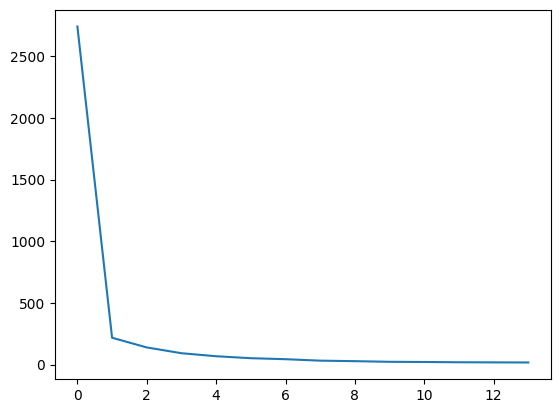

In [16]:
import matplotlib.pyplot as plt

plt.plot(losses)

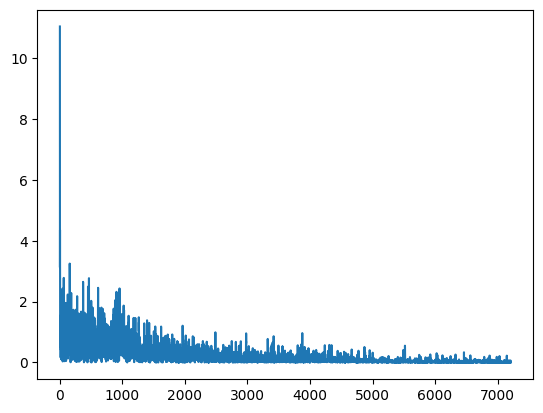

In [17]:
plt.plot(train_losses)

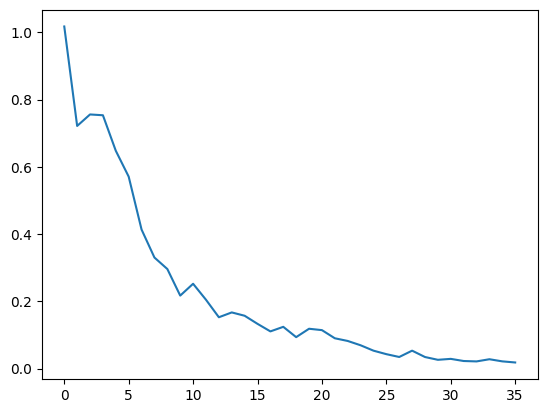

In [20]:
smoothed = smoothe(train_losses, 200)

plt.plot(smoothed)